In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from coverage_plot import coverage_curve, plot_hpd_mask
from runner import (
    run_vsem_experiment, 
    plot_coverage,
    plot_coverage_single_rep,
)

import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind') # whitegrid
sns.set_context("paper", font_scale=1.5)

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

In [3]:
rng = np.random.default_rng(23521)
n_design = 15
n_test_grid_1d = 50
n_reps = 2

tests, metrics, failed = run_vsem_experiment(rng=rng, 
                                             n_design=n_design, 
                                             n_reps=n_reps, 
                                             n_test_grid_1d=n_test_grid_1d)
test = tests[0]

Replication 1


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 64.069387
         Iterations: 39
         Function evaluations: 100
         Gradient evaluations: 88
Replication 2
Optimization terminated successfully.
         Current function value: 61.019413
         Iterations: 95
         Function evaluations: 107
         Gradient evaluations: 107
Number of failed iterations: 0


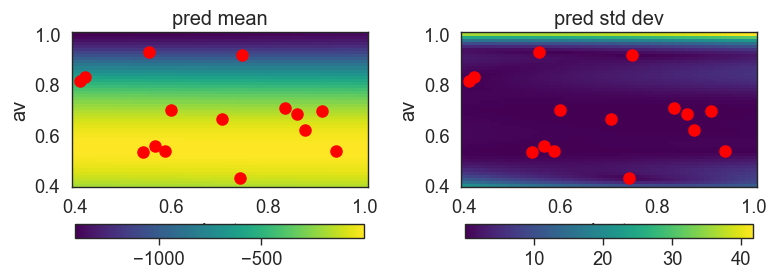

In [4]:
# GP predictions

fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
display(fig_gp)
plt.close()

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/experiments/vsem/vsem_inv_prob.py:1074: RuntimeWarning: overflow encountered in exp
  Z = np.exp(log_Z)


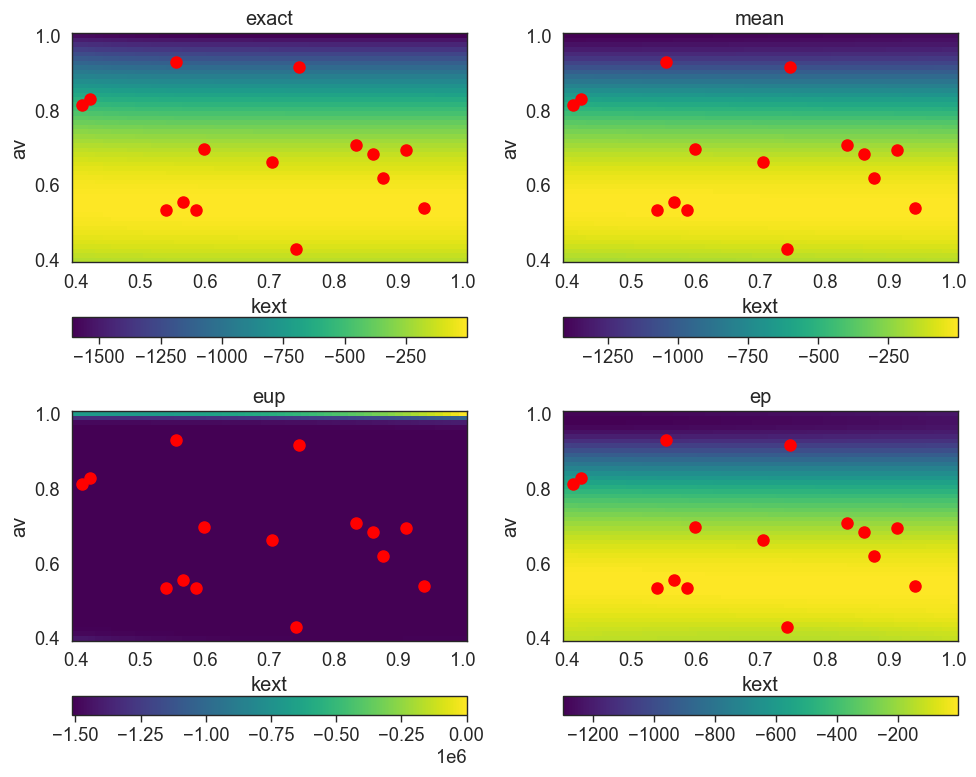

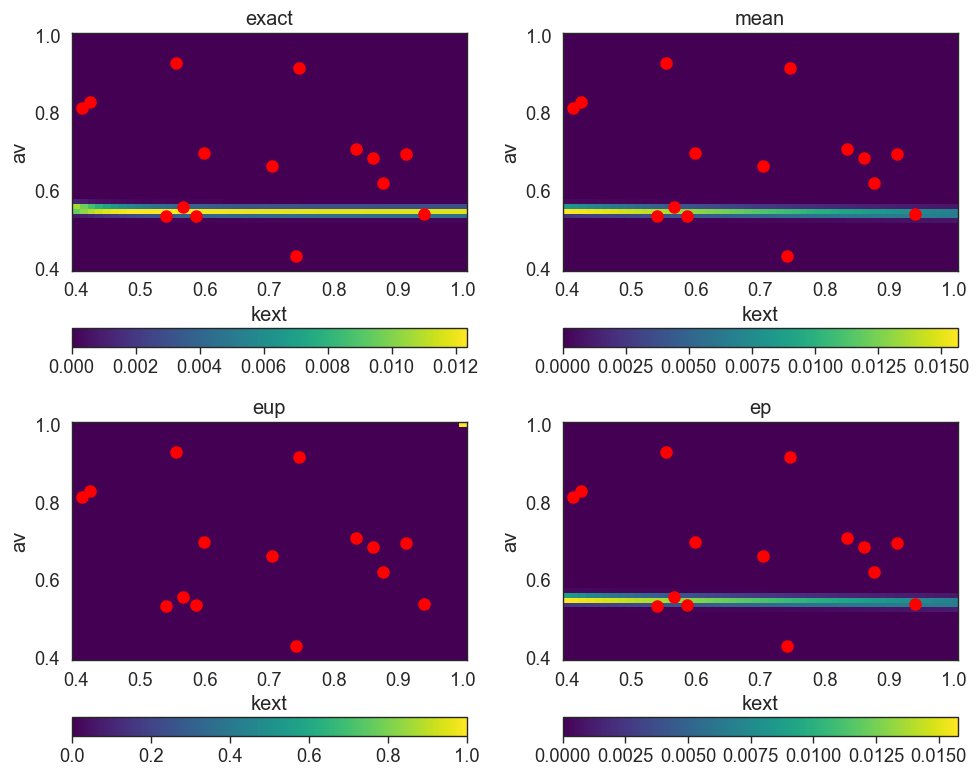

In [5]:
# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type='pred', nrows=2, figsize=(10,8))

display(fig_log)
display(fig)
plt.close()

In [14]:
cell_area = test.test_grid_info['cell_area']
U = test.test_grid_info['U_grid']
n_grid_1d = test.test_grid_info['n_grid_1d']
pred = test.gp_post_pred['pred']

logp_true = test._exact_post_grid(return_log=True)
logp_approx = test.log_post_approx_mean(U, pred=pred)

In [15]:
alphas_out, log_cov, calib_log, masks = coverage_curve(
    logp_true,
    logp_approx,
    cell_area=None,
    alphas=np.concatenate([np.arange(0.1, 1.0, 0.1), np.array([0.99])]),
    return_masks=True,
    expand_ties=True,
    normalized_tol=1e-8
)

In [16]:
print("alpha   log_coverage   coverage (linear)   calib_error_log")
for a, lc, ce in zip(alphas_out, log_cov, calib_log):
    print(f"{a:4.2f}   {lc:12.6f}   {np.exp(lc):12.6e}    {ce:12.6f}")

alpha   log_coverage   coverage (linear)   calib_error_log
0.10      -2.553547   7.780519e-02       -0.250962
0.20      -1.808366   1.639218e-01       -0.198928
0.30      -1.343592   2.609069e-01       -0.139619
0.40      -0.999255   3.681537e-01       -0.082964
0.50      -0.699268   4.969488e-01       -0.006121
0.60      -0.452154   6.362560e-01        0.058671
0.70      -0.339420   7.121836e-01        0.017255
0.80      -0.235844   7.899036e-01       -0.012701
0.90      -0.127996   8.798571e-01       -0.022635
0.99      -0.010661   9.893952e-01       -0.000611


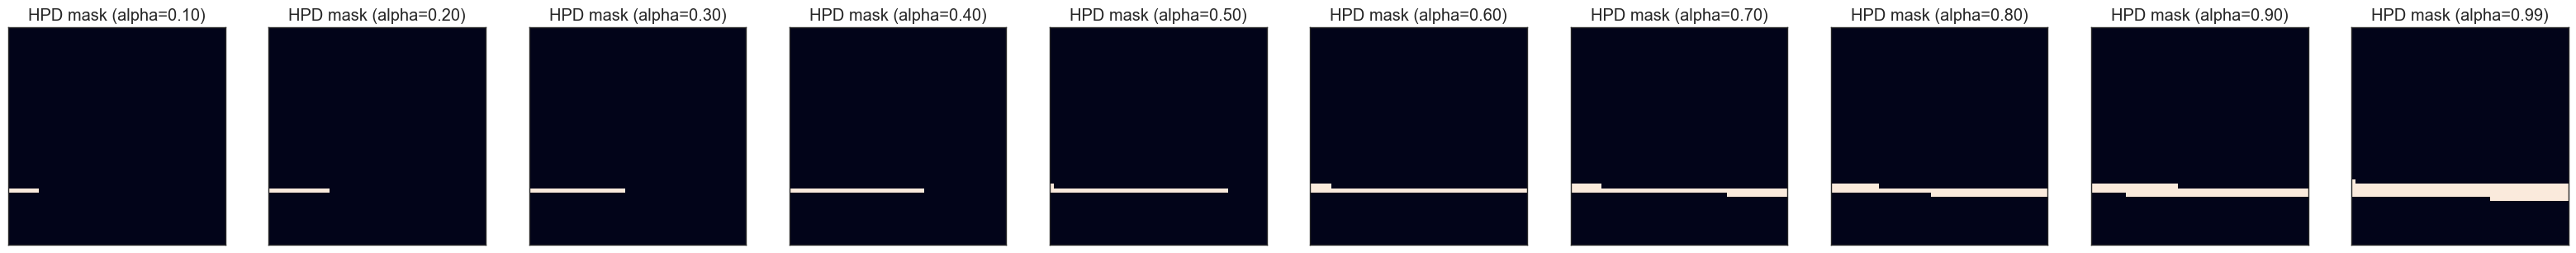

In [17]:
# Plot masks
plt.close()
fig, axes = plt.subplots(1, len(alphas_out), figsize=(4 * len(alphas_out), 4))
for ax, a, mask in zip(axes, alphas_out, masks):
    plot_hpd_mask(mask, grid_shape=(n_grid_1d, n_grid_1d), ax=ax, title=f"HPD mask (alpha={a:.2f})")

plt.show()